<img src="../img/ods_stickers.jpg" />

## 特征工程和特征选择

---

#### 介绍

本次实验通过特征提取、特征转换、特征选择三个过程介绍数据预处理方法，特征提取将原始数据转换为适合建模的特征，特征转换将数据进行变换以提高算法的准确性，特征选择用来删除无用的特征。

#### 知识点

- 特征提取
- 特征转换
- 特征选择

---

本次实验的一些示例将使用 Renthop 公司的数据集。首先载入数据集。

In [ ]:
# 下载数据并解压
!wget -nc "../../data/renthop_train.json.gz"
!gunzip "renthop_train.json.gz"

In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_json('renthop_train.json')
df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,low
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,high
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,low
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street,low


### 特征提取

在实践中，很少有数据是以矩阵形式保存、可以直接使用的，这就是为什么需要对数据进行特征提取。首先看看在一些常见的数据类型中特征提取是如何进行的。

#### 文本数据

文本的处理方法非常多，本次实验介绍最流行的一种处理过程：

- 在处理文本之前，必须对文本进行切分词（tokenzie）操作，也就是将文本切分为单元（token）。在最简单的情形下，一个 token 就是一个单词。但直接按单词切分可能会损失一些信息，比如「Santa Barbara」应该是一个整体，却被切分为 2 个 token。现成的分词器（tokenizer）会考虑语言的特性，但也会出错，特别是当你处理特定来源的文本时（报纸、俚语、误拼、笔误）。
- 接下来需要正则化数据。对文本而言，这涉及词干提取（stemming）和词形还原（lemmatization）方法。这两个方法是词形规范化的两类重要方式，都能够达到有效归并词形的目的，二者既有联系也有区别。两者的区别可以参考《Introduction to Information Retrieval》一书的 [<i class="fa fa-external-link-square" aria-hidden="true"> Stemming and lemmatization</i>](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) 一节。
- 当文档被转换为单词序列之后，就可以用向量表示它。最简单的方法是词袋（Bag of Words）模型：创建一个长度等于字典的向量，计算每个单词出现在文本中的次数，然后将次数放入向量对应的位置中。

下面用代码来表述词袋模型。

In [4]:
import numpy as np
import pandas as pd
texts = ['i have a cat',
         'you have a dog',
         'you and i have a cat and a dog']

vocabulary = list(enumerate(set([word for sentence
                                 in texts for word in sentence.split()])))
print('Vocabulary:', vocabulary)


def vectorize(text):
    vector = np.zeros(len(vocabulary))
    for i, word in vocabulary:
        num = 0
        for w in text:
            if w == word:
                num += 1
        if num:
            vector[i] = num
    return vector


print('Vectors:')
for sentence in texts:
    print(vectorize(sentence.split()))

Vocabulary: [(0, 'i'), (1, 'have'), (2, 'and'), (3, 'you'), (4, 'cat'), (5, 'dog'), (6, 'a')]
Vectors:
[1. 1. 0. 0. 1. 0. 1.]
[0. 1. 0. 1. 0. 1. 1.]
[1. 1. 2. 1. 1. 1. 2.]


下图是一个简化的词袋模型实现过程，在实际应用中，还需要考虑停止词，字典的最大长度等问题。

<img width=50% src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557032863965'>

当使用词袋模型时，文本中的单词顺序信息会丢失，这意味着向量化之后，“i have no cows”（我没有牛）和“no, i have cows”（没，我有牛）会变得一样，尽管事实上它们的意思截然相反。

为了避免这个问题，可以转而使用 N-Gram 模型。下面载入相关库，建立 N-Gram 模型。

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(1, 1))
vect.fit_transform(['no i have cows', 'i have no cows']).toarray()

array([[1, 1, 1],
       [1, 1, 1]], dtype=int64)

打印结果

In [6]:
vect.vocabulary_

{'no': 2, 'have': 1, 'cows': 0}

改变参数，再次建立 N-Gram 模型。

In [7]:
vect = CountVectorizer(ngram_range=(1, 2))
vect.fit_transform(['no i have cows', 'i have no cows']).toarray()

array([[1, 1, 1, 0, 1, 0, 1],
       [1, 1, 0, 1, 1, 1, 0]], dtype=int64)

打印结果。

In [8]:
vect.vocabulary_

{'no': 4,
 'have': 1,
 'cows': 0,
 'no have': 6,
 'have cows': 2,
 'have no': 3,
 'no cows': 5}

除了基于单词生成 N-Gram 模型，在某些情形下，可以基于字符生成 N-Gram 模型，以考虑相关单词的相似性或笔误，下面基于字符生成 N-Gram 模型，并查看它们之间的欧氏距离。

In [9]:
from scipy.spatial.distance import euclidean
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(3, 3), analyzer='char_wb')

n1, n2, n3, n4 = vect.fit_transform(
    ['andersen', 'petersen', 'petrov', 'smith']).toarray()

euclidean(n1, n2), euclidean(n2, n3), euclidean(n3, n4)

(2.8284271247461903, 3.1622776601683795, 3.3166247903554)

有时候，在语料库（数据集的全部文档）中罕见但在当前文本中出现的专业词汇可能会非常重要。因此，通过增加专业词汇的权重把它们和常用词区分开，是很合理的，这一方法称为 TF-IDF（词频-逆向文档频率），其默认选项为：

$$ idf(t,D) = \log\frac{\mid D\mid}{df(d,t)+1} $$

$$ tfidf(t,d,D) = tf(t,d) \times idf(t,D) $$

使用上述这些传统方法及模型，在简单问题上就可能得到不错的效果，可以作为后续模型的基线。然而，倘若不喜欢前面的传统方法，还有 Word2Vec、GloVe、Fasttext 等方法可以选择。

Word2Vec 是词嵌入算法的一个特殊情形。使用 Word2Vec 和类似的模型，不仅可以向量化高维空间（通常是成百上千维的空间）中的单词，还能比较它们的语义相似度。下图演示了一个经典例子：king（王）- man（男）+ woman（女） = queen（皇后）。

![image](https://doc.shiyanlou.com/courses/uid214893-20190505-1557032917121)

值得注意的是，Word2Vec 模型并不理解单词的意思，只是尝试将用于相同的上下文的单词向量放在相近的位置。这样的模型需要在非常大的数据集上训练，使向量坐标能够捕捉语义。

#### 图像数据

处理图像既简单又复杂。简单是因为现在我们可以直接使用某个流行的预训练网络，而不用思考太多；复杂是因为，如果深入图像领域，那么就需要考虑非常多的细节问题。

在 GPU 不够强的年代，图像的特征提取本身是一个非常复杂的领域。我们需要对较低的层进行提取，检测角点、区域边界、色彩分布统计等。如果你对这些经典方法感兴趣，可以看下 skimage 和 SimpleCV 这两个库。

现在，和图像相关的问题，常常可以直接使用卷积神经网络来完成。你不需要从头设计网络架构，从头训练网络，下载一个当前最先进的预训练网络及其权重，“分离”网络的最后一个全连接层，增加针对特定任务的新层，接着在新数据上训练网络即可。这一让预训练网络适应特定任务的过程被称为微调（fine-tuning）。

下图是 fine-tuning 的一个例子。

<img width=60% src='https://doc.shiyanlou.com/courses/uid214893-20190505-1557032976201'>

如果任务仅仅是对图像进行向量化（抽取图像的特征），那么只需移除最后一层，使用前一层的输出即可，下面通过调用 Keras 中的预训练网络进行图像特征抽取。首先加载相关库。

In [10]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from scipy.misc import face
import numpy as np

Using TensorFlow backend.


同时，由于原 ResNet50 模型托管在外网上，速度较慢。我们直接通过实验楼服务器来下载到线上环境指定路径。

加载 Keras 中的预训练网络 ResNet50，且移除最后一层。

In [11]:
resnet_settings = {'include_top': False, 'weights': 'imagenet'}
resnet = ResNet50(**resnet_settings)
resnet.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
_____________________________________

查看所输入的图片，这是一张浣熊图片。

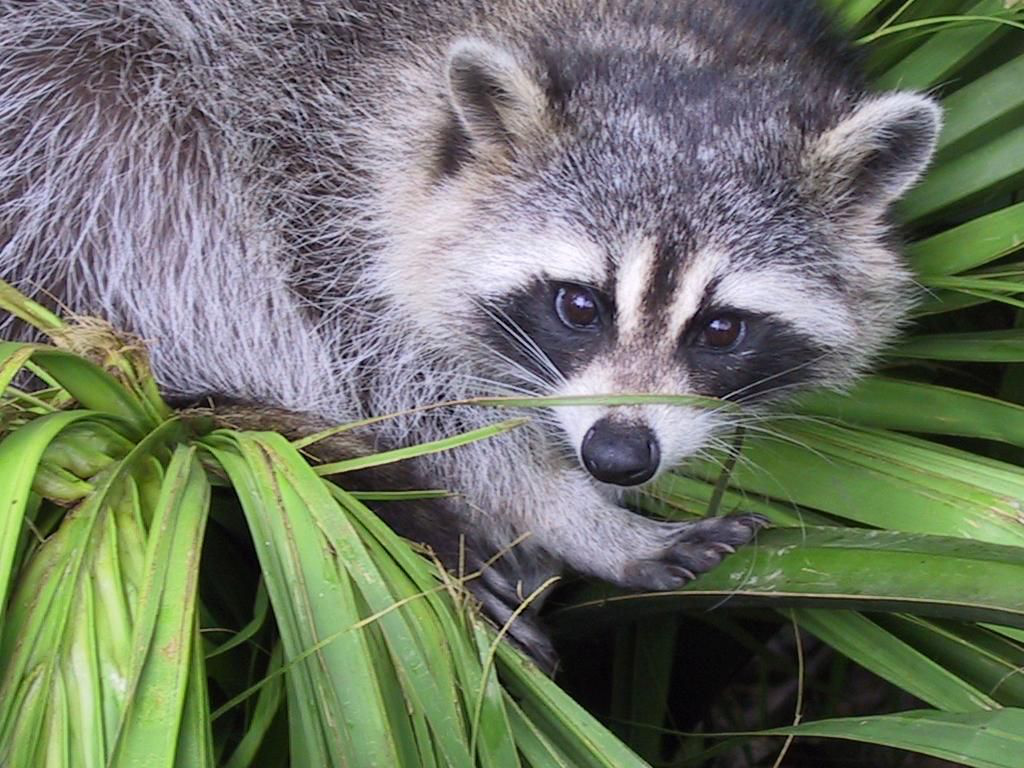

In [12]:
img = image.array_to_img(face())
img

通过 `resise()` 方法将图像尺寸调整为（224，224）。

In [13]:
img = img.resize((224, 224))

通过 `expand_dims()` 方法添加一个额外的维度，以适配网络模型的输入格式，其输入格式为张量形状（batch_size, width, height, n_channels）。

In [14]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
features = resnet.predict(x)
features

array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 1.4725132 , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.38773406, 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 1.8051306 , 0.        , ..., 0.        ,
          0.26263073, 0. 

上面的结果就是抽取的浣熊图像特征矩阵。

如果想识别图像上的文字，无需使用复杂的神经网络，使用 pytesseract 库即可完成。首先载入相关库。

In [ ]:
!pip install pytesseract  # 安装必要的模块
!apt install tesseract-ocr -y
!apt install libtesseract-dev -y

In [16]:
import pytesseract
from PIL import Image
import requests
from io import BytesIO

搜索一张图片并使用 pytesseract 库进行识别。

In [17]:
img = 'https://doc.shiyanlou.com/courses/uid214893-20190430-1556614744119'
img = requests.get(img)
img = Image.open(BytesIO(img.content))
text = pytesseract.image_to_string(img)

打印结果：

In [18]:
text

'Google'

当然，pytesseract 并不能识别所有图片上的文字。比如，下面一张源自 Renthop 的图片，仅能识别其上的几个单词，还有大部分文字无法识别。

In [19]:
img = requests.get(
    'https://doc.shiyanlou.com/courses/uid214893-20190505-1557033014576')
img = Image.open(BytesIO(img.content))
pytesseract.image_to_string(img)

''

#### 地理空间数据

地理空间数据相对文本和图像而言并不那么常见，但掌握处理地理空间数据的基本技术仍然是有用的，并且这一领域中有很多相当成熟的解决方案可以直接使用。

地理空间数据常常以地址或坐标（经纬度）的形式保存。根据任务需求的不同，可能需要用到两种互逆的操作：地理编码（由地址重建坐标点）和逆地理编码（由坐标点重建地址）。在实际项目中，这两个操作都可以通过访问外部 API（谷歌地图或 OpenStreetMap）来使用。不同的地理编码器各有其特性，不同地区的编码质量也不一样。幸运的是，GeoPy 之类的通用库封装了这些操作。

如果有大量数据，那么很快便会达到外部 API 的限制。此外，从 HTTP 获取信息并不总是最快的方案。因此，有必要考虑使用本地版的 OpenStreetMap。

如果只有少量的数据，并且不想使用一些新奇的功能，就可以使用 `reverse_geocoder` 来代替 OpenStreetMap，代码如下。

In [ ]:
!pip install reverse_geocoder  # 安装必要模块

In [21]:
import reverse_geocoder as revgc
revgc.search((df.latitude.iloc[0], df.longitude.iloc[0]))

Loading formatted geocoded file...


[OrderedDict([('lat', '40.74482'),
              ('lon', '-73.94875'),
              ('name', 'Long Island City'),
              ('admin1', 'New York'),
              ('admin2', 'Queens County'),
              ('cc', 'US')])]

处理地理编码时，别忘了地址可能包含错误值，因此需要清洗数据。坐标的错误值较少，但由于 GPS 噪声或特定地点（比如隧道、商业区）的精确度较低，可能导致坐标不准确。如果数据源是移动设备，地理位置可能不是由 GPS 而是由该区域的 WiFi 网络决定的，这会导致出现空间和远距离传送的 Bug，例如，当你经过曼哈顿时，可能会突然碰到芝加哥的 WiFi 地点，出现错误的坐标信息。

>WiFi 的位置追踪功能基于 SSID 和 MAC 地址，同一 SSID 和 MAC 地址可能对应不同的地点，例如，联合供应商标准化 MAC 地址路由，并将其投放于不同城市。甚至一家公司带着路由器搬迁到另一个办公地点都可能造成坐标信息的错误。

地点周边常常有许多基础设施。因此，可以充分发挥想象力，基于生活经验和领域知识自己构建几个特征，如「地点到地铁口的距离」、「建筑物中的商户数」、「到最近的商店的距离」、「周边的 ATM 数目」等。对每个任务都可以很容易的想到几十个特征并从不同的外部资源中获取它们。当地点位于城市以外时，可以考虑从更加专业的数据源获取到的特征，比如海拔。

如果两个以上的地点相互连接，可能有必要基于地点之间的路由提取特征。比如，距离（直线距离和基于路由图计算得出的道路距离），转弯数（包括左转和右转的比例），红路灯数，交叉路口数，桥梁数。

#### 日期和时间数据

你可能认为日期和时间是标准化的，因为它们是如此普遍，不过，其中仍然有一些坑。

有些任务可能需要额外的日历特征。比如，现金提取可能与「账单日」相关联；地铁月卡的购买可能和「月初」相关联。一般而言，处理时序数据时，最好有一份包含公众节假日、异常天气情况及其他重要事件的日历。

处理小时和分钟不像看起来那么简单。如果你将小时作为实数变量，那么 0<23 ，但实际上 0:00:00 02.01>23:00:00 01.01。如果将它们编码为类别变量，那么会生成大量特征，同时丢失时间接近度的信息，即 22 和 23 之间的差异将与 22 和 7 之间的差异相同。

所以，我们可以使用一些更加复杂的方法来处理这些数据，比如将时间投影到圆上，然后使用其 cos 和 sin 值作为两个坐标的值。

In [22]:
def make_harmonic_features(value, period=24):
    value *= 2 * np.pi / period
    return np.cos(value), np.sin(value)

这一转换保留了时间点间的距离，对于需要估计距离的算法（kNN、SVM、k-均值等）使用这种方法来处理时间数据会很有帮助。下面计算经这种方法转化后 23 点和 1 点的距离。

In [23]:
from scipy.spatial import distance
euclidean(make_harmonic_features(23), make_harmonic_features(1))

0.5176380902050424

计算 9 点和 11 点的距离

In [24]:
euclidean(make_harmonic_features(9), make_harmonic_features(11))

0.5176380902050414

计算 9 点和 22 点的距离

In [25]:
euclidean(make_harmonic_features(9), make_harmonic_features(22))

1.9828897227476208

上面结果可知，它们之间的距离各不相同，距离信息被保留。

#### Web 数据

Web 数据通常有用户的 User Agent 信息，这个信息非常重要，首先，从中可以提取操作系统信息。其次，可以据此创建 「is_mobile」（是否是移动端）特征。最后，可以通过它查看到浏览器类别。下面看看是如何操作的。

首先，加载相关库和数据。

In [ ]:
!pip install user_agents  # 安装所需模块

In [27]:
import user_agents

ua = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/56.0.2924.76 Chrome/56.0.2924.76 Safari/537.36'
ua = user_agents.parse(ua)

打印结果。

In [28]:
print('Is a bot? ', ua.is_bot)
print('Is mobile? ', ua.is_mobile)
print('Is PC? ', ua.is_pc)
print('OS Family: ', ua.os.family)
print('OS Version: ', ua.os.version)
print('Browser Family: ', ua.browser.family)
print('Browser Version: ', ua.browser.version)

Is a bot?  False
Is mobile?  False
Is PC?  True
OS Family:  Ubuntu
OS Version:  ()
Browser Family:  Chromium
Browser Version:  (56, 0, 2924)


除了操作系统和浏览器外，你还可以查看 referrer、Accept-Language 和其他元信息。

另一个有用的特征是 IP 地址，基于该数据可以提取出国家，乃至城市、网络运营商、连接类型（是否为移动网络）等信息。当然，该特征可能由于代理和数据库过期导致提取出的信息不准确，出现噪声。网络管理专家可能会尝试提取出更专业的信息，比如是否使用 VPN。另外，IP 地址数据和 Accept-Languag 是一对优秀的组合，它们可以互相印证：如果用户的 IP 地址显示在智利，而浏览器的本地化设为 ru_RU（俄罗斯），那么该用户的所在地就不清楚了，我们需要查看对应的特征栏 「is_traveler_or_proxy_user」（是旅行者还是代理用户）。

### 特征转换

对有些算法而言，特征转换是关键，而对另一些算法而言，该转换则毫无帮助。不是所有人都有能力或者愿意去进行特征转换，这是为什么决策树及其变体（随机森林、梯度提升）变得更加流行，因为它们在异常分布上的鲁棒性很好。

#### 标准化和分布变换

最简单的转换是标准缩放（Standard Scaling），又称 Z 值标准化（Z-score normalization）：

$$ z= \frac{x-\mu}{\sigma} $$

注意，严格意义上说，标准缩放并不生成正态分布，下面验证这一结论，首先载入相关库。

In [29]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import beta
from scipy.stats import shapiro
import numpy as np

使用夏皮罗-威尔克检验（Shapiro–Wilk test）查看数据是否符合正态分布，首先输出原数据的检测统计量和假设检验所得的 p 值。

In [30]:
data = beta(1, 10).rvs(1000).reshape(-1, 1)
shapiro(data)

(0.8632055521011353, 1.2426352779491647e-28)

然后输出经标准缩放处理后数据的检测统计量和假设检验所得的 p 值。

In [31]:
shapiro(StandardScaler().fit_transform(data))

(0.8632055521011353, 1.2426352779491647e-28)

夏皮罗-威尔克检验计算所得的 p 值说明原数据和经标准缩放处理后的数据都不符合正态分布。

不过，某种程度上而言，标准缩放能为离散值提供一些帮助。下面使用 `StandarScaler()` 方法对离散值进行标准缩放。

In [32]:
data = np.array([1, 1, 0, -1, 2, 1, 2, 3, -2, 4, 100]
                ).reshape(-1, 1).astype(np.float64)
StandardScaler().fit_transform(data)

array([[-0.31922662],
       [-0.31922662],
       [-0.35434155],
       [-0.38945648],
       [-0.28411169],
       [-0.31922662],
       [-0.28411169],
       [-0.24899676],
       [-0.42457141],
       [-0.21388184],
       [ 3.15715128]])

也可以直接用公式进行标准缩放。

In [33]:
(data - data.mean()) / data.std()

array([[-0.31922662],
       [-0.31922662],
       [-0.35434155],
       [-0.38945648],
       [-0.28411169],
       [-0.31922662],
       [-0.28411169],
       [-0.24899676],
       [-0.42457141],
       [-0.21388184],
       [ 3.15715128]])

另一个相当流行的选项是极小极大缩放（MinMax Scaling），将所有数据点纳入一个预先规定的区间（通常是 [0,1]）。

$$ X_{norm}=\frac{X-X_{min}}{X_{max}-X_{min}} $$

下面用 `MinMaxScaler()` 方法进行极小极大缩放。

In [34]:
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler().fit_transform(data)

array([[0.02941176],
       [0.02941176],
       [0.01960784],
       [0.00980392],
       [0.03921569],
       [0.02941176],
       [0.03921569],
       [0.04901961],
       [0.        ],
       [0.05882353],
       [1.        ]])

也可以直接用公式进行极小极大缩放。

In [35]:
(data - data.min()) / (data.max() - data.min())

array([[0.02941176],
       [0.02941176],
       [0.01960784],
       [0.00980392],
       [0.03921569],
       [0.02941176],
       [0.03921569],
       [0.04901961],
       [0.        ],
       [0.05882353],
       [1.        ]])

标准缩放和极小极大缩放的应用类似，常常可以互相替换。然而，如果算法涉及计算数据点或向量之间的距离，默认的选项是标准缩放。而在可视化时，极小极大缩放很有用，因为它可以将特征纳入 [0,255] 区间。

如果某些数据并非正态分布，但可以由 [<i class="fa fa-external-link-square" aria-hidden="true"> 对数正态分布</i>](https://en.wikipedia.org/wiki/Log-normal_distribution) 刻画，那么这些数据很容易就能转换为正态分布，下面生成可以用对数正态分布来刻画的数据，并查看其是否符合正态分布。

In [36]:
from scipy.stats import lognorm

data = lognorm(s=1).rvs(1000)
shapiro(data)

(0.6570976376533508, 9.53583604973038e-41)

上面结果表明生成的原数据不符合正态分布。下面将它进行转换，查看转换后的数据是否符合正态分布。

In [37]:
shapiro(np.log(data))

(0.9988785982131958, 0.8044737577438354)

上述结果表明，转换后的数据符合正态分布。

对数正态分布适用于描述薪水、安保费用、城区人口、网络文章评论等信息。然而，底层分布不一定非得是对数正态分布才能应用这一过程，它可以被应用于任何右重尾的分布。此外，还可以尝试使用其他类似的转换，这类转换的例子包括 Box-Cox 转换（对数转换是 Box-Cox 转换的一个特例）和 Yeo-Johnson 转换（将应用范围扩展至负数）。此外，也可以尝试在特征上加上一个常量：`np.log (x + const)`。

在上述例子中处理的都是合成数据，并都使用夏皮罗-威尔克检验严格地测试正态分布。下面来处理一些真实数据，并使用分位图（Q-Q plot）测试正态分布，正态分布的分位图看起来像一条平滑的对角线，而异常值可以通过这样的方法被直观地理解。但要注意分位图方法不像夏皮罗-威尔克检测那么正式。

首先载入相关库。

In [38]:
import statsmodels.api as sm

从 Renthop 数据集中获取价格特征，并过滤最极端的值，使画出来的图比较清晰。

In [39]:
price = df.price[(df.price <= 20000) & (df.price > 500)]
price_log = np.log(price)
price_mm = MinMaxScaler().fit_transform(
    price.values.reshape(-1, 1).astype(np.float64)).flatten()
price_z = StandardScaler().fit_transform(
    price.values.reshape(-1, 1).astype(np.float64)).flatten()

绘制初始特征分位图。

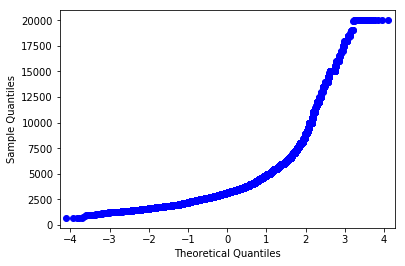

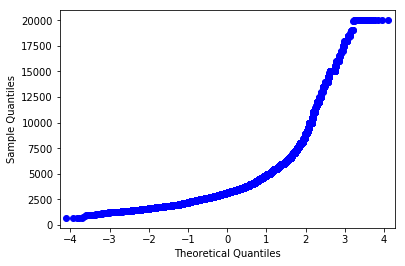

In [40]:
sm.qqplot(price, loc=price.mean(), scale=price.std())

对原数据应用标准缩放，画出标准缩放后的分位图。

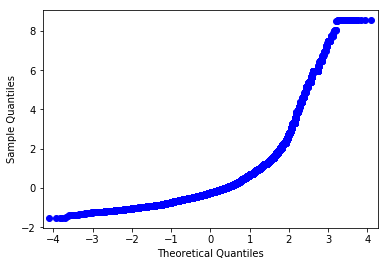

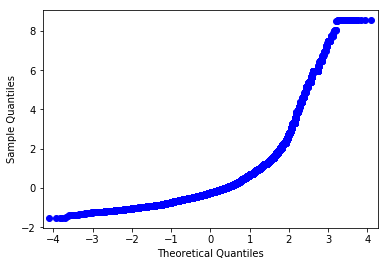

In [41]:
sm.qqplot(price_z, loc=price_z.mean(), scale=price_z.std())

上图可见应用标准缩放后分位图形状并未改变。对原数据应用极小极大缩放，画出分位图。

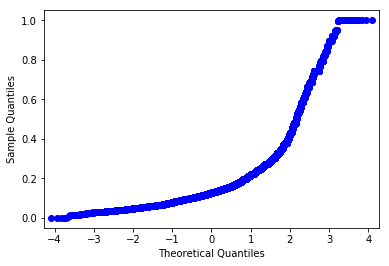

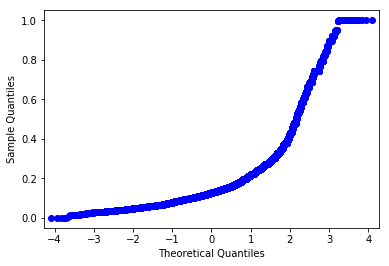

In [42]:
sm.qqplot(price_mm, loc=price_mm.mean(), scale=price_mm.std())

上图可见，极小极大缩放后分位图形状依旧不变。对原数据取对数，画出分位图。

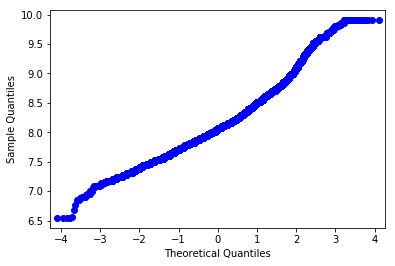

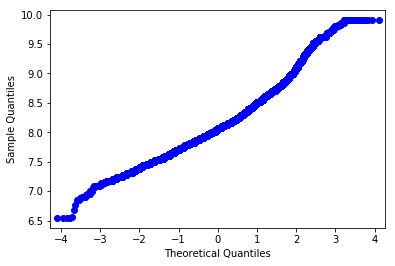

In [43]:
sm.qqplot(price_log, loc=price_log.mean(), scale=price_log.std())

上图可见对原数据取对数后，数据更接近正态分布。

#### 相互作用

如果前面的转换看起来更像是由数学驱动的，那这一小节更多地牵涉数据的本质。它既可以算特征转换，也可以算特征创建。

看一个出租房屋的问题，使用的依旧是 Renthop 公司的数据集。该数据集的其中两个特征是「房间数」和「价格」。一般「每间房的价格」比「总价格」具有更多的指示信息，下面生成这一特征。

In [44]:
rooms = df["bedrooms"].apply(lambda x: max(x, .5))
df["price_per_bedroom"] = df["price"] / rooms

在此过程中，要添加一些限制条件。因为如果将特征数限定在一定数目以下，就可以生成所有可能的相互作用，然后使用一些技术去除不必要的特征。此外，并非所有特征的相互作用都有实际意义；比如，线性模型中常用的多项式特征 [<i class="fa fa-external-link-square" aria-hidden="true"> sklearn.preprocessing.PolynomialFeatures</i>](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) 几乎无法被解释。

#### 缺失值补全

很多算法无法处理缺失值，而真实数据常常都包含缺失值。幸运的是，Pandas 和 sklearn 都提供了易于使用的解决方案：`pandas.DataFrame.fillna` 和 `sklearn.preprocessing.Imputer`。

这些解决方案处理缺失值的方式很直接：

- 将缺失值编码为一个单独的空值，比如，类别变量使用 n/a 值；
- 使用该特征最可能的值（数值变量使用均值或中位数，类别变量使用最常见的值）；
- 或者，反其道而行之，使用某个极端值（比较适合决策树，因为这样使得决策树模型可以在缺失值和未缺失值间分割）；
- 对于有序数据（列如时序数据），使用相邻值。

有时库提供的解决方案会建议使用固定值，比如 df = df.fillna(0)，不再为缺失值浪费时间。然而，这并非最佳方案，因为数据预处理比创建模型花去的时间更多，因此简单的使用固定值可能会埋下隐患，损害模型。

### 特征选择

为什么要进行特征选择？下面是两个重要的原因：

- 数据越多，计算复杂度越高。而在真实的环境中，很容易碰上有数百个额外特征的数据。
- 部分算法会将噪声（不含信息量的特征）视作信号，导致过拟合。

#### 统计学方法

最先考虑移除的特征就是那些值不变的特征，即不包含信息的特征。沿着这一思路，那些方差较低的特征很可能不如方差较高的特征重要。所以，可以考虑移除方差低于特定阈值的特征。

下面实验一下，首先，生成具有 20 个特征的数据 x_data_generated。

In [45]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import make_classification

x_data_generated, y_data_generated = make_classification()
x_data_generated.shape

(100, 20)

移除方差低于阈值（0.9）的特征。

In [46]:
VarianceThreshold(.9).fit_transform(x_data_generated).shape

(100, 14)

可以看到，移除了部分特征。下面对比一下原数据 x_data_generated 和移除部分特征后的数据 x_data_varth。首先载入相关库。

In [47]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

移除方差低于阈值（0.9）的特征，得到 x_data_varth。

In [48]:
x_data_varth = VarianceThreshold(.9).fit_transform(x_data_generated)

建立逻辑回归模型，在这个模型上对比 x_data_generated 和 x_data_varth。

In [49]:
logit = LogisticRegression(solver='lbfgs', random_state=17)

比较结果。

In [50]:
print(cross_val_score(logit, x_data_generated, y_data_generated,
                      scoring='neg_log_loss', cv=5).mean())
cross_val_score(logit, x_data_varth, y_data_generated,
                scoring='neg_log_loss', cv=5).mean()

-0.513793222609363


-0.477658695408659

上面结果表明，选取特征提高了分类器的表现，虽然这个例子是使用的合成数据，但在真实问题上依旧值得使用特征选择。

#### 建模选取

特征选择的另一种方法是使用某个基线模型评估特征，因为模型会表明特征的重要性。常用的两类模型是：随机森林和搭配 Lasso 正则的线性模型。这种方法的逻辑很简单：如果在简单模型中一些特征明显没用，那就没有必要将它们拖入更复杂的模型。下面实验一下这种方法，首先载入相关库。

In [51]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

合成一些数据。

In [52]:
x_data_generated, y_data_generated = make_classification()

建立基线模型。

In [53]:
rf = RandomForestClassifier(n_estimators=10, random_state=17)
pipe = make_pipeline(SelectFromModel(estimator=rf), logit)

比较结果。

In [54]:
print(cross_val_score(logit, x_data_generated, y_data_generated,
                      scoring='neg_log_loss', cv=5).mean())
print(cross_val_score(rf, x_data_generated, y_data_generated,
                      scoring='neg_log_loss', cv=5).mean())
print(cross_val_score(pipe, x_data_generated, y_data_generated,
                      scoring='neg_log_loss', cv=5).mean())

-0.5124249591820398
-1.1201528526721884
-0.3864257779481845


上面结果表明此次建模选取特征改善了模型表现。当然，建模选取也有可能导致模型表现下降。

#### 网格搜索

最后，介绍最可靠但计算复杂度最高的方法：网格搜索。

在特征子集上训练模型，储存结果，在不同子集上重复这一过程，比较模型的质量以识别最佳特征集，这一方法被称为穷尽特征选取 [<i class="fa fa-external-link-square" aria-hidden="true"> Exhaustive Feature Selection</i>](http://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/)。

搜索所有组合通常会花去太长的时间，因此可以尝试缩减搜索空间。固定一个较小的数字 N，迭代所有 N 特征的组合，选定最佳组合，接着迭代 N+1 特征组合，其中，之前的最佳组合固定不变，仅仅考虑一个新特征。重复这些迭代过程，直到达到特征最大值，或者直到模型的表现停止明显的提升。这一算法被称为循序特征选取 [<i class="fa fa-external-link-square" aria-hidden="true"> Sequential Feature Selection</i>](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/)。

下面代码通过调用 `SequentialFeatureSelector()` 方法实现了循序特征选择。

In [ ]:
!pip install mlxtend

In [56]:
from mlxtend.feature_selection import SequentialFeatureSelector

selector = SequentialFeatureSelector(logit, scoring='neg_log_loss',
                                     verbose=2, k_features=3, forward=False, n_jobs=-1)

selector.fit(x_data_generated, y_data_generated)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.7s finished

[2019-05-21 06:16:00] Features: 19/3 -- score: -0.46534612515439716[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    1.1s finished

[2019-05-21 06:16:01] Features: 18/3 -- score: -0.4373643882780966[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.6s finished

[2019-05-21 06:16:02] Features: 17/3 -- score: -0.41222482008032246[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.4s finished

[2019-05-21 06:16:02] Features: 16/3 -- score: -0.3985660117554966[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concu

SequentialFeatureSelector(clone_estimator=True, cv=5,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
             floating=False, forward=False, k_features=3, n_jobs=-1,
             pre_dispatch='2*n_jobs', scoring='neg_log_loss', verbose=2)

### 实验总结

在机器学习领域，数据集的质量好坏直接决定了所建立的模型性能水平，因此学会数据预处理是十分重要的。本次实验介绍了特征提取、特征转换、特征选择的基本内容和常用方法，熟悉数据预处理的过程。

<i class="fa fa-link" aria-hidden="true"> 相关链接</i>
- [<i class="fa fa-external-link-square" aria-hidden="true"> 了解实验楼《楼+ 机器学习和数据挖掘课程》</i>](https://www.shiyanlou.com/louplus/)